In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from tqdm import tqdm
mpl.rcParams['figure.dpi']= 200

In [15]:
data = pd.read_csv("Breast_GSE70947.csv")
data = data.to_numpy()
y = data[:,1]
y = 1 * (y == 'normal')
X = data[:,2:]
# splitting the data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
np.savetxt("X_train.csv", X_train, delimiter=",")
np.savetxt("X_test.csv", X_test, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

In [7]:
# checking the sets are balanced (so checking proportions of each class)
np.unique(y_train, return_counts=True)[1]/y_train.shape[0]
np.unique(y_test, return_counts=True)[1]/y_test.shape[0]
# compare against original dataset proportions
np.unique(y, return_counts=True)[1]/y.shape[0]

array([0.49480969, 0.50519031])

In [20]:
X_train = pd.read_csv("X_train.csv")
X_train = X_train.to_numpy()
X_test = pd.read_csv("X_test.csv")
X_test = X_test.to_numpy()
y_train = pd.read_csv("y_train.csv")
y_train = y_train.to_numpy()
y_test = pd.read_csv("y_test.csv")
y_test = y_test.to_numpy()

## Random Forest Classifier

In [ ]:
# TRAIING
# on a bunch of models, first do 5-fold CV, then choose "best" one, finally test model on test data
depths = np.int64(np.linspace(1, 50, 25, endpoint=True))
rfc_cv_scores = []
rfc_models = []
for depth in tqdm(depths):
    rfc = RandomForestClassifier(max_depth=depth, n_estimators=15, max_features=1, bootstrap=True, random_state=0) # check what random state's for
    score = np.mean(cross_val_score(rfc, X_train, y_train, cv=5))
    print("depth " + str(depth) + ": " + str(score))
    rfc_cv_scores = rfc_cv_scores + [score]
    rfc_models = rfc_models + [rfc]
    # if depth == depths[-1]:
    #     pickle.dump(rfc, open("rf_model", "wb"))
rfc_optim_model = rfc_models[np.argmax(rfc_cv_scores)]
pickle.dump(rfc_optim_model, open("rf_model", "wb"))

In [16]:
# PREDICT
#  now we try on test data, note that you can just run this cell instead of training models above ^, rf_model stores the tuned RF. 
rfc_optim_model = pickle.load(open("rf_model", "rb"))
rfc_optim_model.fit(X_train, y_train)
rfc_optim_model.score(X_test, y_test)

0.8356164383561644

## AdaBoost

In [ ]:
# TRAINING
# on a bunch of models, first do 5-fold CV, then choose "best" one, finally test model on test data
estimators = [1, 5, 15, 25, 50, 75]
ada_cv_scores = []
ada_models = []
for estimator in tqdm(estimators):
    abc = AdaBoostClassifier(n_estimators=estimator)    
    score = np.mean(cross_val_score(abc, X_train, y_train, cv=5))
    print("estimator " + str(estimator) + ": " + str(score))
    ada_cv_scores = ada_cv_scores + [score]
    ada_models = ada_models + [abc]
ada_optim_model = ada_models[np.argmax(ada_cv_scores)]
pickle.dump(ada_optim_model, open("ada_model", "wb"))

In [18]:
# PREDICT
# now we try on test data, same as before - no need to run cell above again, just run the model
ada_optim_model = pickle.load(open("ada_model", "rb"))
ada_optim_model.fit(X_train, y_train)
ada_optim_model.score(X_test, y_test)

0.8904109589041096

## XGBoost

In [44]:
# TRAINING
# We have many hyper-parameters to tune, so RandomizedSearchCV might be better to use here
# Note that before we tuned for n_estimators and max_depth, so we can just use those in XGBoost
params = {'learning_rate': [0.1, 0.01, 0.001],
            'max_depth': [5, 10, 15, 20, 25, 30],
            'n_estimators': [100, 200, 300, 400, 500],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [0, 0.1, 0.5, 1]}
xgb_model = xgb.XGBClassifier()
rs_classifier = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, cv=5, n_jobs=-1)
rs_classifier.fit(X_train, y_train)
xgb_optim_model = xgb.XGBClassifier(**rs_classifier.best_params_)
pickle.dump(xgb_optim_model, open("xgb_model", "wb"))

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.5, 0.7, 0.9]})

In [17]:
# PREDICT
xgb_optim_model = pickle.load(open("xgb_model", "rb"))
xgb_optim_model.fit(X_train, y_train)
xgb_optim_model.score(X_test, y_test)

0.9041095890410958

## Confusion Matrices for Models
(just use the variable where you store your model in predict in first line)

In [ ]:
cm = metrics.confusion_matrix(y_test, rfc_optim_model.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative', 'Predicted Positive'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative', 'Actual Positive'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## ROC/AUC

Text(0.5, 1.0, 'ROC for Ensemble Methods')

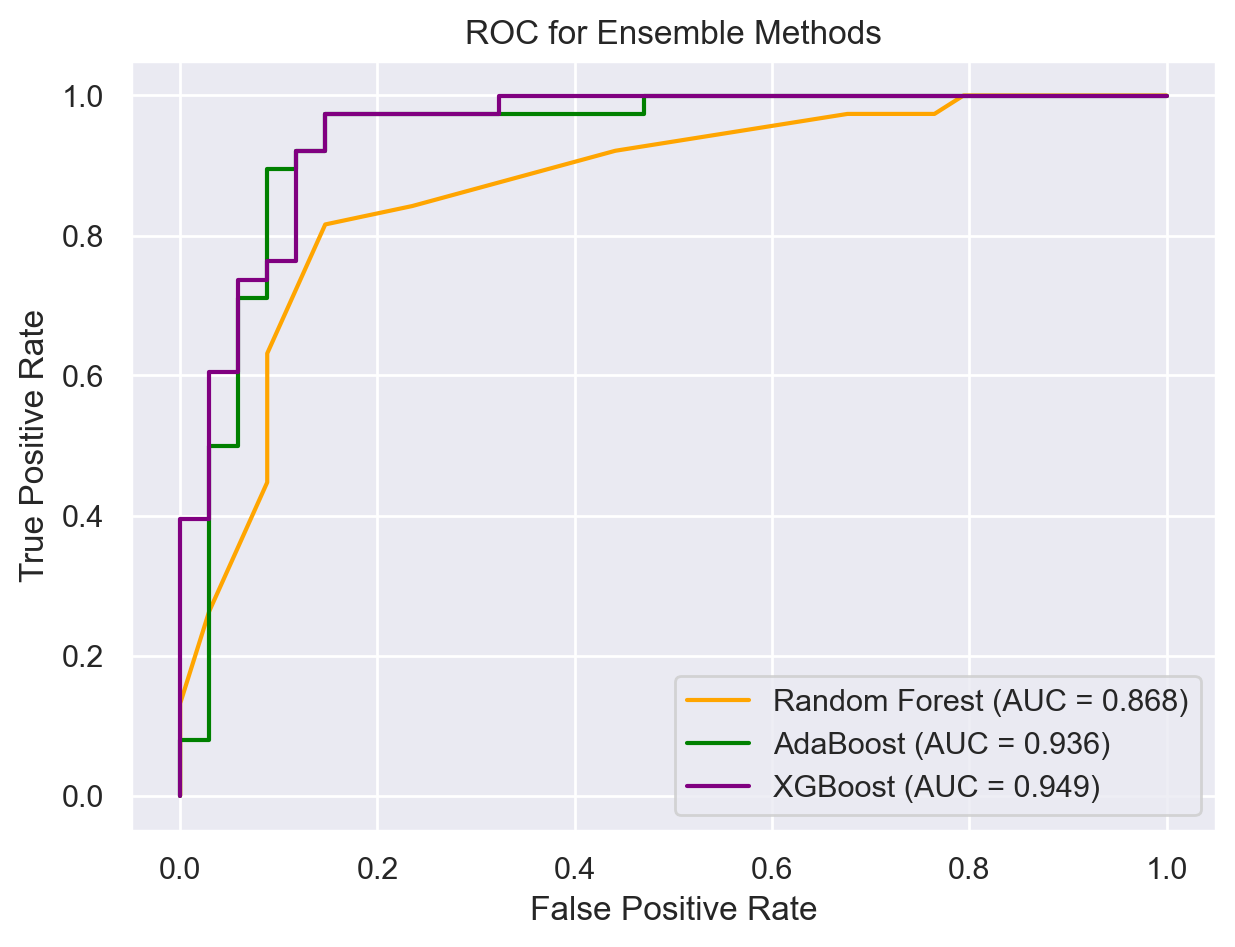

In [35]:
sns.set(rc={"figure.figsize":(7,5)})
rf_auc = round(roc_auc_score(y_test, rfc_optim_model.predict_proba(X_test)[:,1]), 3)
ada_auc = round(roc_auc_score(y_test, ada_optim_model.predict_proba(X_test)[:,1]), 3)
xgb_auc = round(roc_auc_score(y_test, xgb_optim_model.predict_proba(X_test)[:,1]), 3)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rfc_optim_model.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, _ = metrics.roc_curve(y_test, ada_optim_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_test, xgb_optim_model.predict_proba(X_test)[:,1])
plt.plot(rf_fpr, rf_tpr, label="Random Forest (AUC = " + str(rf_auc) + ")", color="orange")
plt.plot(ada_fpr, ada_tpr, label="AdaBoost (AUC = " + str(ada_auc) + ")", color="green")
plt.plot(xgb_fpr, xgb_tpr, label="XGBoost (AUC = " + str(xgb_auc) + ")", color="purple")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC for Ensemble Methods")

In [ ]:
# sns.set(rc={"figure.figsize":(12,5)})
# sns.lineplot(x=depths,y=rfc_cv_scores, marker="o")
# plt.xlabel("Forest depth")
# plt.ylabel("Average 5-fold CV score")
# plt.title("Determining RF depth via CV")
# #plt.savefig("rfs_cv.png")

# sns.set(rc={"figure.figsize":(12,5)})
# sns.lineplot(x=estimators,y=ada_cv_scores, marker="o")
# plt.xlabel("# of estimators (weak learners)")
# plt.ylabel("Average 5-fold CV score")
# plt.title("Determining AdaBoost Estimators via CV")
# #plt.savefig("adaboost_cv.png")